In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
import re
# 図のスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("ライブラリ読み込み完了")
import japanize_matplotlib


ライブラリ読み込み完了


In [2]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df
def get_first_trigger_segment(df, trigger_col="value", trigger_value=2):
    """
    最初のトリガー値(trigger_value)が立ってから
    次のトリガーが立つ直前までの区間を返す。
    """

    trigger_idx = df.index[df[trigger_col] >= trigger_value].tolist()
    print(trigger_idx)


    if len(trigger_idx) == 0:
        return None  # トリガーが無い

    # 最初のトリガー開始
    start = trigger_idx[0]

    # 次のトリガーがあるか？
    # if len(trigger_idx) >= 2:
        # end = trigger_idx[-1]
    # else:
    end = df.index[-1]  # トリガーが1回だけの場合、最後まで
    
    print(start,end)

    return df.loc[start:end].reset_index(drop=True)

def fix_columns(df):
    cleaned = [re.sub(r'\.\d+$', '', c) for c in df.columns]  # .1 や .2 を除去
    new_cols = []
    seen = {}

    for col in cleaned:
        if col not in seen:
            seen[col] = 1
            new_cols.append(f"{col}_1")
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")

    df.columns = new_cols
    return df

def estimate_sampling_rate(df):
    t = df['time'].values
    # 時刻差分（dt）を計算
    dt = np.diff(t)
    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]
    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)
    # sampling rate [Hz]
    fs = 1.0 / dt_med
    return fs, dt_med



def plot_shifted_cop(df, shift_samples):
    # シフトした列を追加
    df_plot = df.copy()
    df_plot["COP_Y_shift"] = df_plot["COP_Y"].shift(shift_samples)
    df_plot["COP_X_shift"] = df_plot["COP_X"].shift(shift_samples)

    # === COP_Y vs 圧力中心行 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_Y_shift'], color='blue', label=f'COP_Y (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心行_2'], color='orange', label='圧力中心行')

    ax1.set_title(f"COP_Y Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    # === COP_X vs 圧力中心列 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_X_shift'], color='blue', label=f'COP_X (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心列_2'], color='orange', label='圧力中心列')

    ax1.set_title(f"COP_X Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    return df_plot
# df_shift = plot_shifted_cop(df_all, shift_samples=10)


In [3]:
from scipy.signal import butter, filtfilt

# サンプルDataFrameの作成
def create_sample_data():
    np.random.seed(42)
    fs = 100  # サンプリング周波数 [Hz]
    t = np.arange(0, 10, 1/fs)
    
    # 信号生成
    clean_signal = 2 * np.sin(2 * np.pi * 1 * t)  # 1Hzの信号
    noise = 0.5 * np.random.normal(0, 1, len(t))  # ノイズ
    
    df = pd.DataFrame({
        'time': t,
        'original_signal': clean_signal,
        'noisy_signal': clean_signal + noise,
        'sensor_A': clean_signal + noise + 0.3 * np.sin(2 * np.pi * 5 * t),
        'sensor_B': clean_signal * 0.8 + noise * 1.2,
        'category': np.random.choice(['A', 'B', 'C'], len(t))
    })
    return df


# 双方向ローパスフィルタ関数
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    双方向ローパスフィルタを適用
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# 特定の列にフィルタを適用
def apply_filter_to_column(df, column_name, cutoff_freq, sampling_freq, order=4):
    """
    DataFrameの特定の列にフィルタを適用
    """
    filtered_data = butter_lowpass_filter(
        df[column_name].values, 
        cutoff_freq, 
        sampling_freq, 
        order
    )
    
    # 新しい列名を作成
    new_column_name = f"{column_name}_filtered"
    df[new_column_name] = filtered_data
    
    return df, new_column_name


class DataFrameLowpassFilter:


    def __init__(self, sampling_freq, cutoff_freq, order=4):
        self.sampling_freq = sampling_freq
        self.cutoff_freq = cutoff_freq
        self.order = order
    
    def _design_filter(self):
        """フィルタ係数を設計"""
        nyquist = 0.5 * self.sampling_freq
        normal_cutoff = self.cutoff_freq / nyquist
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def filter_column(self, data):
        """単一のデータ列にフィルタを適用"""
        b, a = self._design_filter()
        return filtfilt(b, a, data)
    
    def filter_dataframe(self, df, columns, suffix='_filtered'):
        """
        DataFrameの複数列にフィルタを適用
        
        Parameters:
        df: pandas DataFrame
        columns: フィルタ適用する列名のリスト
        suffix: 新しい列名に追加する接尾辞
        """
        df_filtered = df.copy()
        
        for col in columns:
            if col in df.columns:
                filtered_data = self.filter_column(df[col].values)
                new_col_name = f"{col}{suffix}"
                df_filtered[new_col_name] = filtered_data
            else:
                print(f"警告: 列 '{col}' はDataFrameに存在しません")
        
        return df_filtered

# # 使用例
# filter_processor = DataFrameLowpassFilter(
#     sampling_freq=100, 
#     cutoff_freq=5, 
#     order=4
# )

# # 複数列を一度にフィルタリング
# columns_to_process = ['noisy_signal', 'sensor_A', 'sensor_B']
# df_filtered = filter_processor.filter_dataframe(df, columns_to_process)

# print(df_filtered.columns.tolist())

In [4]:
data_info = pd.read_excel("info.xlsx")
data_info

,sub,seat,cop,pedal,steer,label
0,A,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
1,B,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
2,A,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F


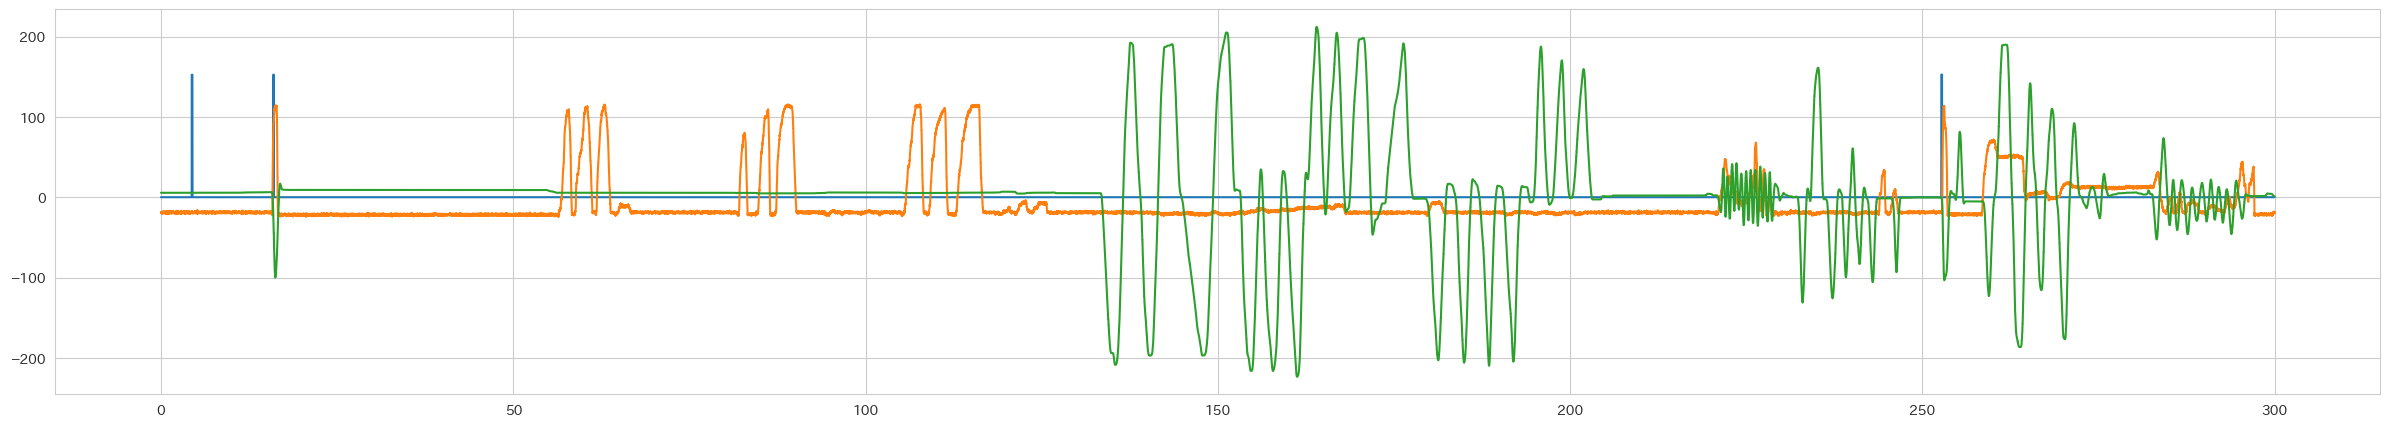

[436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 25268, 25269, 25270, 25271, 25272, 25273, 25274, 25275, 25276, 25277, 25278]
436 30000


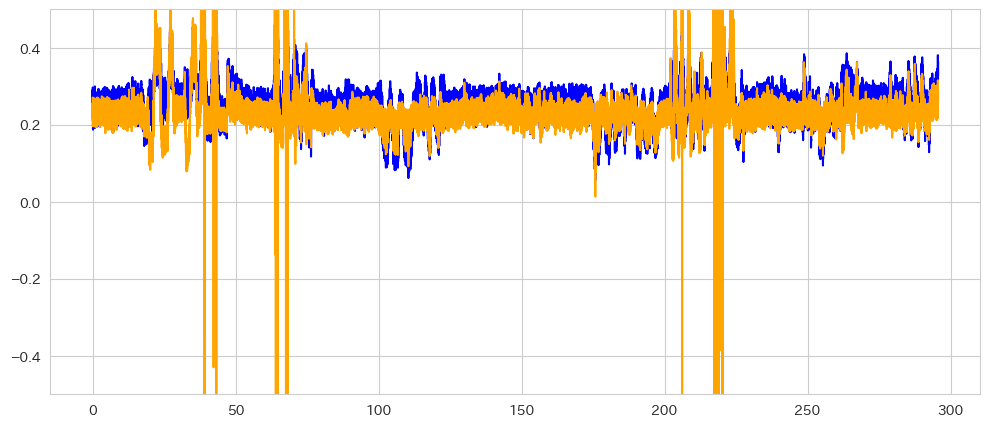

Sampling rate: 41.66666666666509 Hz


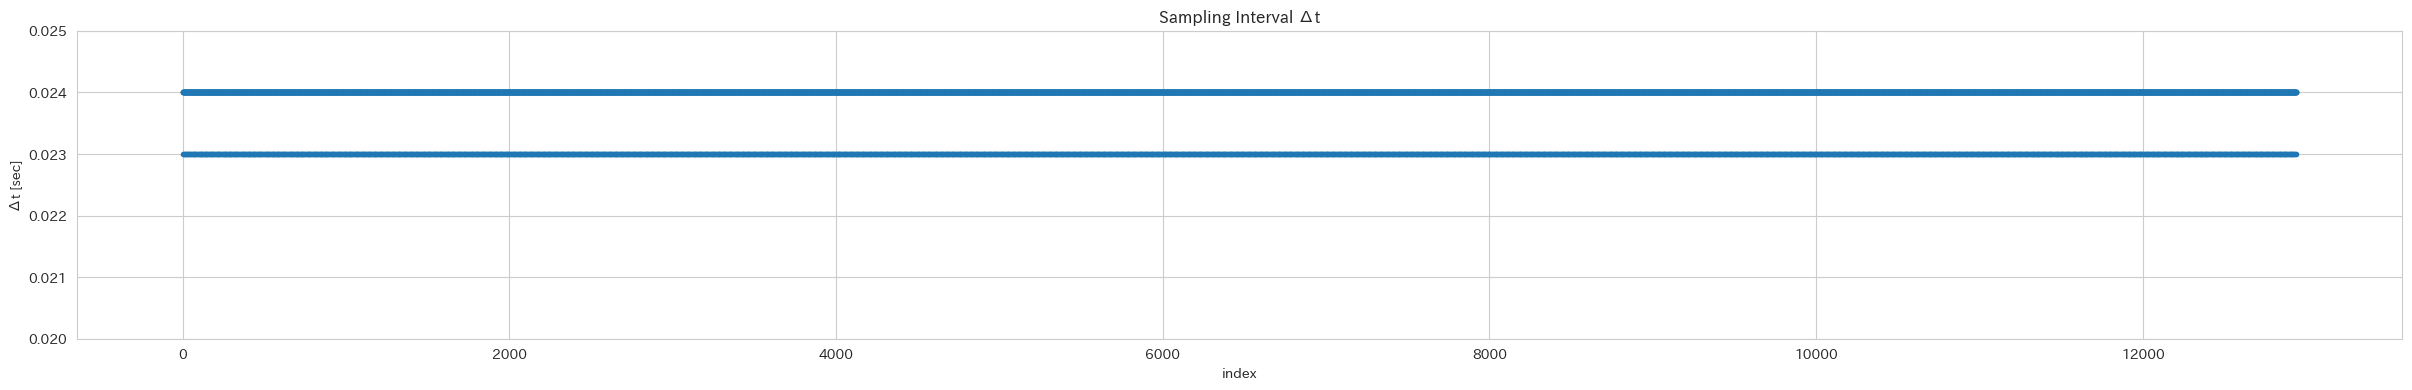

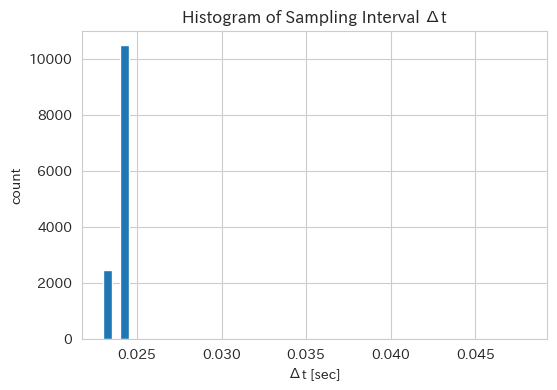

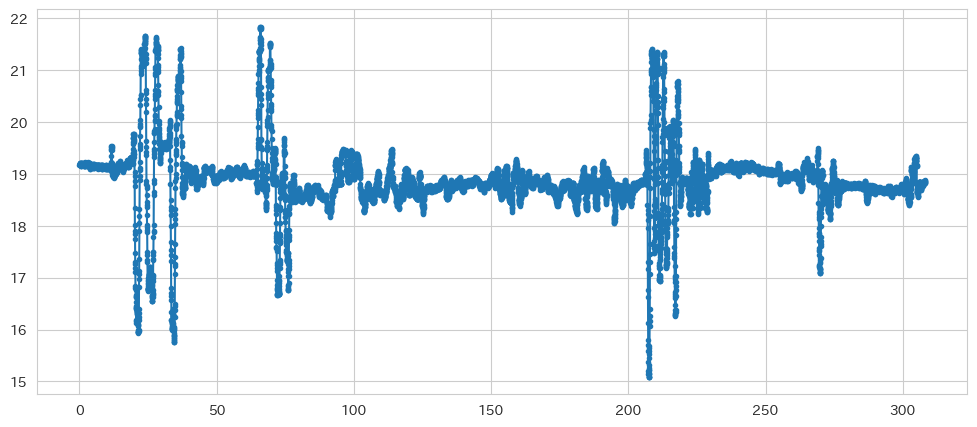

In [ ]:
for num, idx in enumerate(data_info.index): 
    row = data_info.iloc[idx,:] 
    sub_ = row['sub'] 
    seat_path = row['seat']
    cop_path = row['cop']
    pedal_path = row['pedal']
    steer_path = row['steer']
    label = row['label']

    if label != "3F":
        continue

    df_seat = pd.read_csv(seat_path,skiprows=1)
    df_cop = pd.read_csv(cop_path,skiprows=21)
    df_pedal = pd.read_csv(pedal_path,skiprows=21)
    df_steer = pd.read_csv(steer_path,skiprows=21)

    if label == "2F":
        df_pedal.rename(columns={'Untitled 1':'pedal'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
        df_cop.rename( columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)

    elif label =="3F":
        df_pedal.rename(columns={'Untitled 2':'pedal','Untitled 5':'trg','Untitled':'timestamp','Untitled 7':'next_due_pedal'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer','Untitled 7':'next_due_steer','Untitled':'timestamp'},inplace=True)
        df_cop.rename(columns={'Untitled':'F1','Untitled 1':'F2','Untitled 2':'F3','Untitled 3':'F4','Untitled 4':'FX','Untitled 5':'FY','Untitled 7':'next_due_seat'},inplace=True)


    df_pedal = make_time_row(df_pedal)
    df_steer = make_time_row(df_steer)
    df_cop = make_time_row(df_cop)
    
    df_mock = pd.merge(df_cop[['time','F1','F2','F3','F4','FX','FY']], df_steer[['time','steer']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
    df_mock = pd.merge(df_mock, df_pedal[['time','pedal','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 


    plt.figure(figsize=(30,5))
    plt.plot(df_mock.time,df_mock.trg*10)
    plt.plot(df_mock.time,df_mock.pedal*10)
    plt.plot(df_mock.time,df_mock.steer)
    plt.show()


    df_mock_tmp = get_first_trigger_segment(df_mock, trigger_col="trg", trigger_value=1)
    df_mock_tmp['time'] -= df_mock_tmp['time'].iloc[0]
    plt.plot(df_mock_tmp.time,df_mock_tmp['FY'],'-',color='blue')
    plt.plot(df_mock_tmp.time,df_mock_tmp['FX'],'-',color='orange')
    plt.ylim(-0.5,0.5)
    plt.show()

    df_seat = fix_columns(df_seat)
    df_seat['time'] = df_seat['時間_1']
    fs, dt = estimate_sampling_rate(df_seat)
    print("Sampling rate:", fs, "Hz")

    # time 差分（サンプリング間隔）
    dt = df_seat['time'].diff()

    plt.figure(figsize=(30,4))
    plt.plot(dt,'.')
    plt.title("Sampling Interval Δt")
    plt.xlabel("index")
    plt.ylabel("Δt [sec]")
    plt.ylim(0.020,0.025)
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(6,4))
    plt.hist(dt.dropna(), bins=50)
    plt.title("Histogram of Sampling Interval Δt")
    plt.xlabel("Δt [sec]")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()

    plt.plot(df_seat.time,df_seat['圧力中心列_2'],'.-')

    
    # break


--- Processing Start ---
Column 'FX' (Thresh=5.0): Detected 14 outliers.
Column 'FY' (Thresh=1.0): Detected 0 outliers.
--- Processing End ---



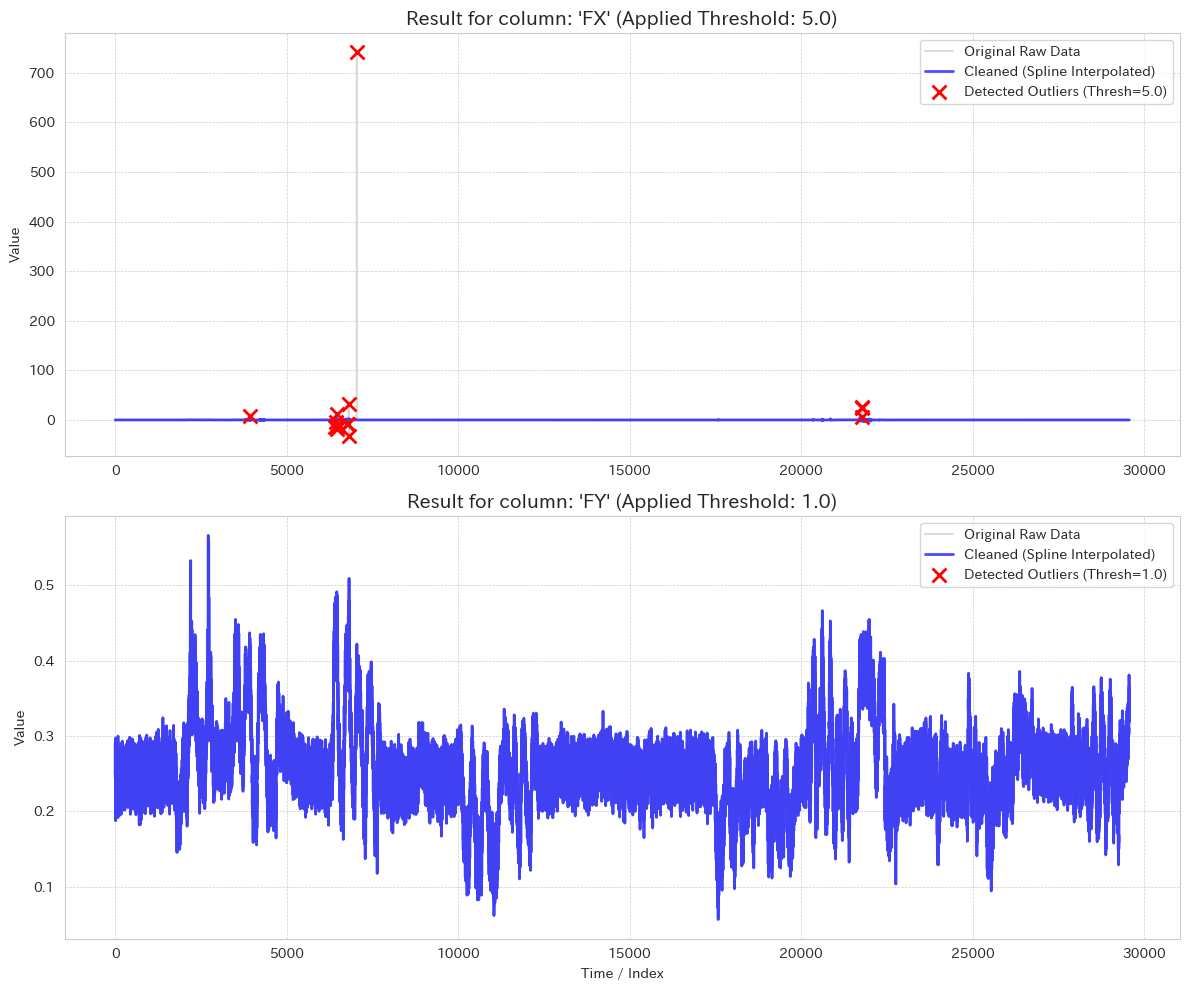

In [6]:
# --- 修正済みの関数 ---
def clean_outliers_spline_multi(df_input, threshold_dict, window=11):
    """
    カラムごとに異なる閾値で外れ値を検知し、スプライン補間で埋める関数。
    (インデックス重複や不整合によるエラーを回避する .values 版)
    """
    # 元データを変更しないようコピー
    df_result = df_input.copy()
    
    for col, thresh in threshold_dict.items():
        if col not in df_result.columns:
            continue

        # 1. トレンド推定（Seriesのまま計算）
        # rollingはインデックスを維持するため、そのまま使います
        rolling_obj = df_result[col].rolling(window=window, center=True)
        rolling_median = rolling_obj.median()
        
        # 2. 残差スコア計算 & 3. 閾値判定
        # 【重要修正ポイント】 .values をつけて Numpy配列同士として計算します。
        # これによりインデックスの不整合によるエラーを回避します。
        diff = df_result[col].values - rolling_median.values
        score = np.abs(diff)
        
        # マスクもNumpy配列(True/Falseのリスト)になります
        outlier_mask = score > thresh
        
        # ログ表示（numpyのsumを使います）
        n_outliers = np.sum(outlier_mask) 
        print(f"Column '{col}' (Thresh={thresh}): Detected {n_outliers} outliers.")
        
        if n_outliers > 0:
            # 4. 外れ値をNaNに置換
            # .loc は Numpy配列のマスク(True/False)をそのまま受け取れます
            df_result.loc[outlier_mask, col] = np.nan
            
            # 5. スプライン補間
            # limit_direction='both'で端も埋めます
            df_result[col] = df_result[col].interpolate(method='spline', order=3, limit_direction='both')
            
    return df_result

# ==========================================
#  実行と確認プロット
# ==========================================

# 1. テスト用データの作成（正常な時系列データ）
# np.random.seed(42)
# t = np.linspace(0, 100, 300) # 点数を少し増やして滑らかに

# # カラムA (FX): 変動が小さいデータ
# col_a = np.sin(t / 5) + np.random.normal(0, 0.1, 300)
# col_a[50] = 4.5   # 上スパイク
# col_a[120] = -3.5 # 下スパイク

# # カラムB (Sensor): 変動が激しいデータ（振幅が大きい）
# col_b = 5 * np.cos(t / 5) + np.random.normal(0, 0.5, 300) 
# col_b[200] = 18.0 # 巨大なスパイク
# col_b[205:210] = -15.0 # 幅のある異常

# df_mock = pd.DataFrame({'FX': col_a, 'Sensor': col_b}, index=t)

# 2. 設定（辞書で閾値を個別指定）
# FXは厳しく(1.0)、Sensorは緩く(4.0)
settings = {
    'FX': 5.0,
    'FY': 1.0 
}

# 3. 関数を実行（修正済み関数を使用）
print("--- Processing Start ---")
df_cleaned = clean_outliers_spline_multi(df_mock_tmp, threshold_dict=settings, window=15)
print("--- Processing End ---\n")

# --- 復活させた結果確認プロット ---
fig, axes = plt.subplots(len(settings), 1, figsize=(12, 10))

# 辞書のキー（カラム名）を使って順番にプロット
for i, col in enumerate(settings.keys()):
    # 元データ（薄いグレーで表示）
    axes[i].plot(df_mock_tmp.index, df_mock_tmp[col], label='Original Raw Data', color='lightgray', alpha=0.8, linewidth=1.5)
    
    # 補間後データ（青色で表示）
    axes[i].plot(df_cleaned.index, df_cleaned[col], label='Cleaned (Spline Interpolated)', color='blue', linewidth=2, alpha=0.7)
    
    # 除去された点（赤いバツ印で強調）
    # 元データと補間後データが異なる場所を探します
    removed_points = df_mock_tmp[df_mock_tmp[col] != df_cleaned[col]]
    axes[i].scatter(removed_points.index, removed_points[col], color='red', marker='x', s=100, linewidth=2, label=f'Detected Outliers (Thresh={settings[col]})', zorder=5)
    
    # グラフの体裁を整える
    axes[i].set_title(f"Result for column: '{col}' (Applied Threshold: {settings[col]})", fontsize=14)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].set_ylabel('Value')

axes[-1].set_xlabel('Time / Index')
plt.tight_layout()
plt.show()

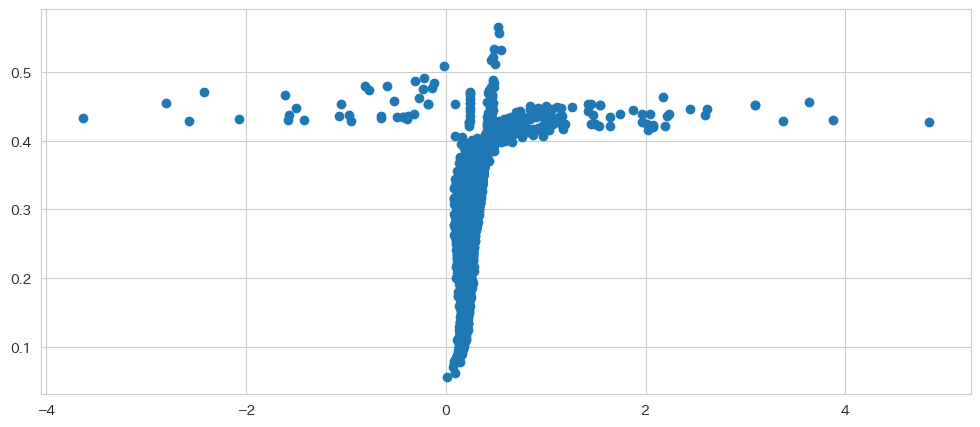

In [8]:
plt.scatter(df_cleaned.FX,df_cleaned.FY)

# ずれ量探索

['time', 'F1', 'F2', 'F3', 'F4', 'FX', 'FY', 'steer', 'pedal', 'trg', 'FX_filtered', 'FY_filtered']


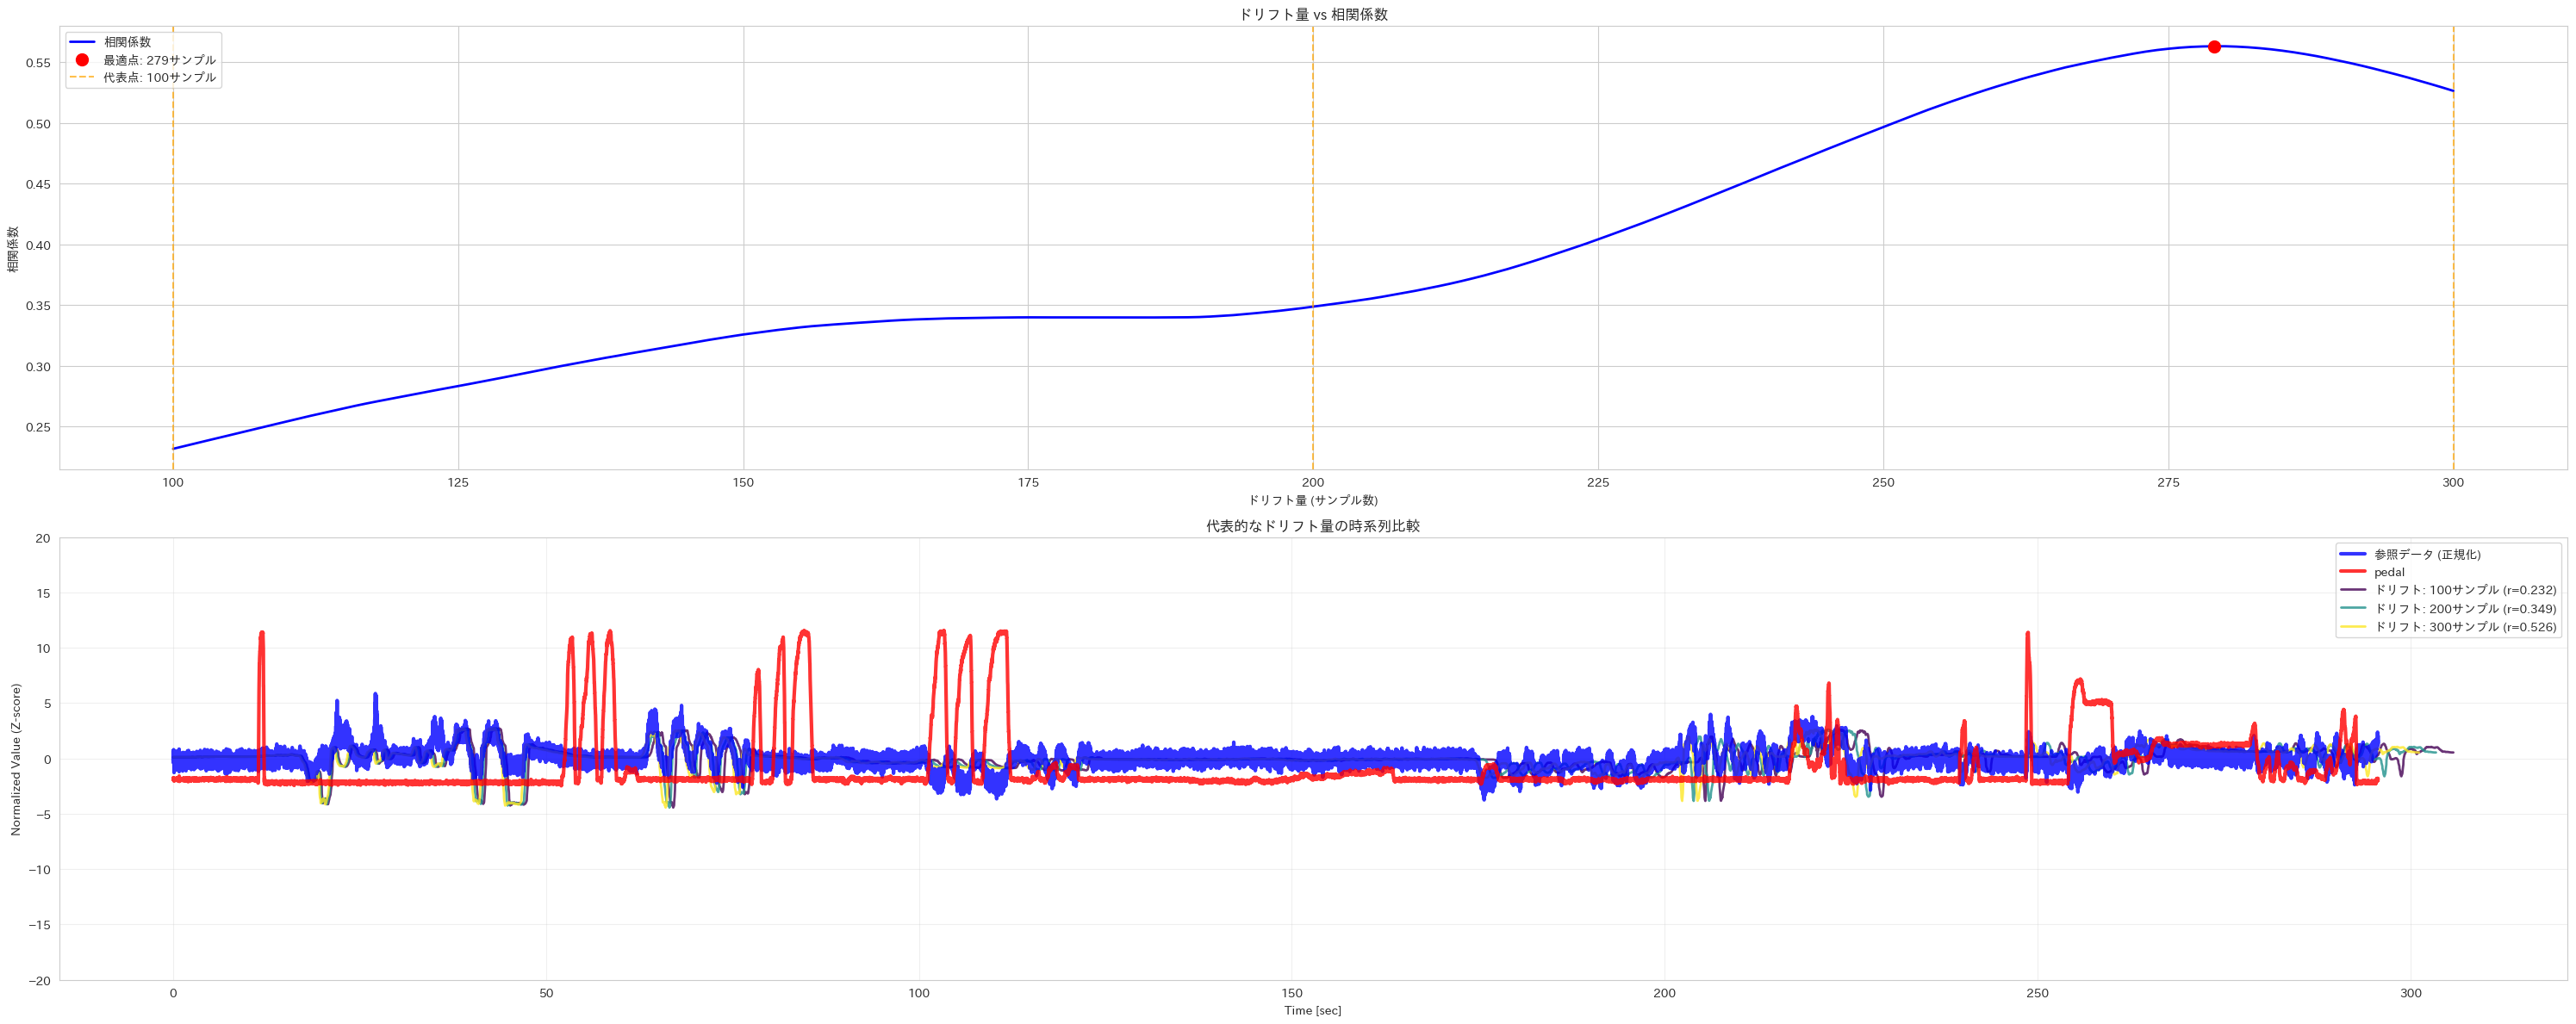


=== 探索結果サマリー ===
探索範囲: 100 ~ 300 サンプル
最適なドリフト量: 279 サンプル
最大相関係数: 0.5630

=== 代表サンプル詳細 ===
   ドリフト 100 サンプル: 相関係数 = 0.2317
   ドリフト 200 サンプル: 相関係数 = 0.3487
   ドリフト 300 サンプル: 相関係数 = 0.5263


In [ ]:
def evaluate_linear_drifts_with_samples(df_ref, df_target, drift_range, 
                                       col_ref='COP_X', col_target='圧力中心列_2',
                                       num_sample_views=3):
    """
    線形ドリフトの評価＋代表的なサンプルを時系列グラフで表示
    """
    
    # --- 1. 前処理: 正規化 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start # 全体長さ
    
    # --- 3. 全範囲で相関計算 ---
    all_results = []
    for drift_samples in range(drift_range[0], drift_range[1] + 1):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 相関計算
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
        else:
            correlation = -1
            
        all_results.append((drift_samples, correlation))
    
    # 結果をソート
    all_results.sort(key=lambda x: x[0])
    drifts, corrs = zip(*all_results)
    
    # --- 4. 代表サンプルの選択 ---
    if len(drifts) <= num_sample_views:
        sample_drifts = drifts
    else:
        # 最小、中央、最大から選択
        indices = [
            0,  # 最小
            len(drifts) // 2,  # 中央
            len(drifts) - 1  # 最大
        ]
        sample_drifts = [drifts[i] for i in indices]
    
    # --- 5. 可視化 ---
    fig = plt.figure(figsize=(30, 12))
    
    # 5-1. 相関グラフ
    ax1 = plt.subplot(2, 1, 1)
    best_idx = np.argmax(corrs)
    plt.plot(drifts, corrs, 'b-', linewidth=2, label='相関係数')
    plt.plot(drifts[best_idx], corrs[best_idx], 'ro', markersize=10, 
             label=f'最適点: {drifts[best_idx]}サンプル')
    
    # 代表サンプルを縦線で表示
    for drift in sample_drifts:
        idx = drifts.index(drift)
        plt.axvline(x=drift, color='orange', linestyle='--', alpha=0.7,
                   label=f'代表点: {drift}サンプル' if drift == sample_drifts[0] else "")
    
    plt.xlabel('ドリフト量 (サンプル数)')
    plt.ylabel('相関係数')
    plt.title('ドリフト量 vs 相関係数')
    plt.grid(True)
    plt.legend()
    
    # 5-2. 時系列比較グラフ
    ax2 = plt.subplot(2, 1, 2)
    
    # 参照データ
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=3, 
             alpha=0.8, label='参照データ (正規化)', zorder=10)
    plt.plot(df_ref['time'], df_ref['pedal'], color='red', linewidth=3, 
             alpha=0.8, label='pedal', zorder=10)
    
    # カラーマップ
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_drifts)))
    
    # 各代表サンプルの時系列をプロット
    for i, drift_samples in enumerate(sample_drifts):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # このドリフト量での相関係数を検索
        drift_corr = next((corr for drift, corr in all_results if drift == drift_samples), 0)
        
        plt.plot(new_time, target_norm, 
                 color=colors[i], linewidth=2, alpha=0.8,
                 label=f'ドリフト: {drift_samples}サンプル (r={drift_corr:.3f})')
    
    plt.title('代表的なドリフト量の時系列比較')
    plt.xlabel('Time [sec]')
    plt.ylabel('Normalized Value (Z-score)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 後半部分を拡大表示
    # plt.xlim(200, 300)
    plt.ylim(-20, 20)
    
    plt.tight_layout()
    plt.show()
    
    # --- 6. 結果表示 ---
    print("\n=== 探索結果サマリー ===")
    print(f"探索範囲: {drift_range[0]} ~ {drift_range[1]} サンプル")
    print(f"最適なドリフト量: {drifts[best_idx]} サンプル")
    print(f"最大相関係数: {corrs[best_idx]:.4f}")
    
    print(f"\n=== 代表サンプル詳細 ===")
    for drift in sample_drifts:
        idx = drifts.index(drift)
        marker = "★" if drift == drifts[best_idx] else "  "
        print(f"{marker} ドリフト {drift:3d} サンプル: 相関係数 = {corrs[idx]:.4f}")
    
    return all_results, sample_drifts

# ==========================================
# 実行例
# ==========================================

filter_processor = DataFrameLowpassFilter(
    sampling_freq=100, 
    cutoff_freq=5, 
    order=1
)

# 複数列を一度にフィルタリング
columns_to_process = ['FX', 'FY']
df_filtered = filter_processor.filter_dataframe(df_cleaned, columns_to_process)

print(df_filtered.columns.tolist())


all_results, sample_drifts = evaluate_linear_drifts_with_samples(
    df_filtered, #df_cleaned,
    df_seat, 
    drift_range=[100,300],  # 探索範囲
    # col_ref='FY_filtered',
    # col_target='荷重(N)_1',

    col_ref='FY', 
    col_target='圧力中心行_1',
    num_sample_views=3  # 表示する代表点の数
)

# リサンプリングパラメータあてはめ

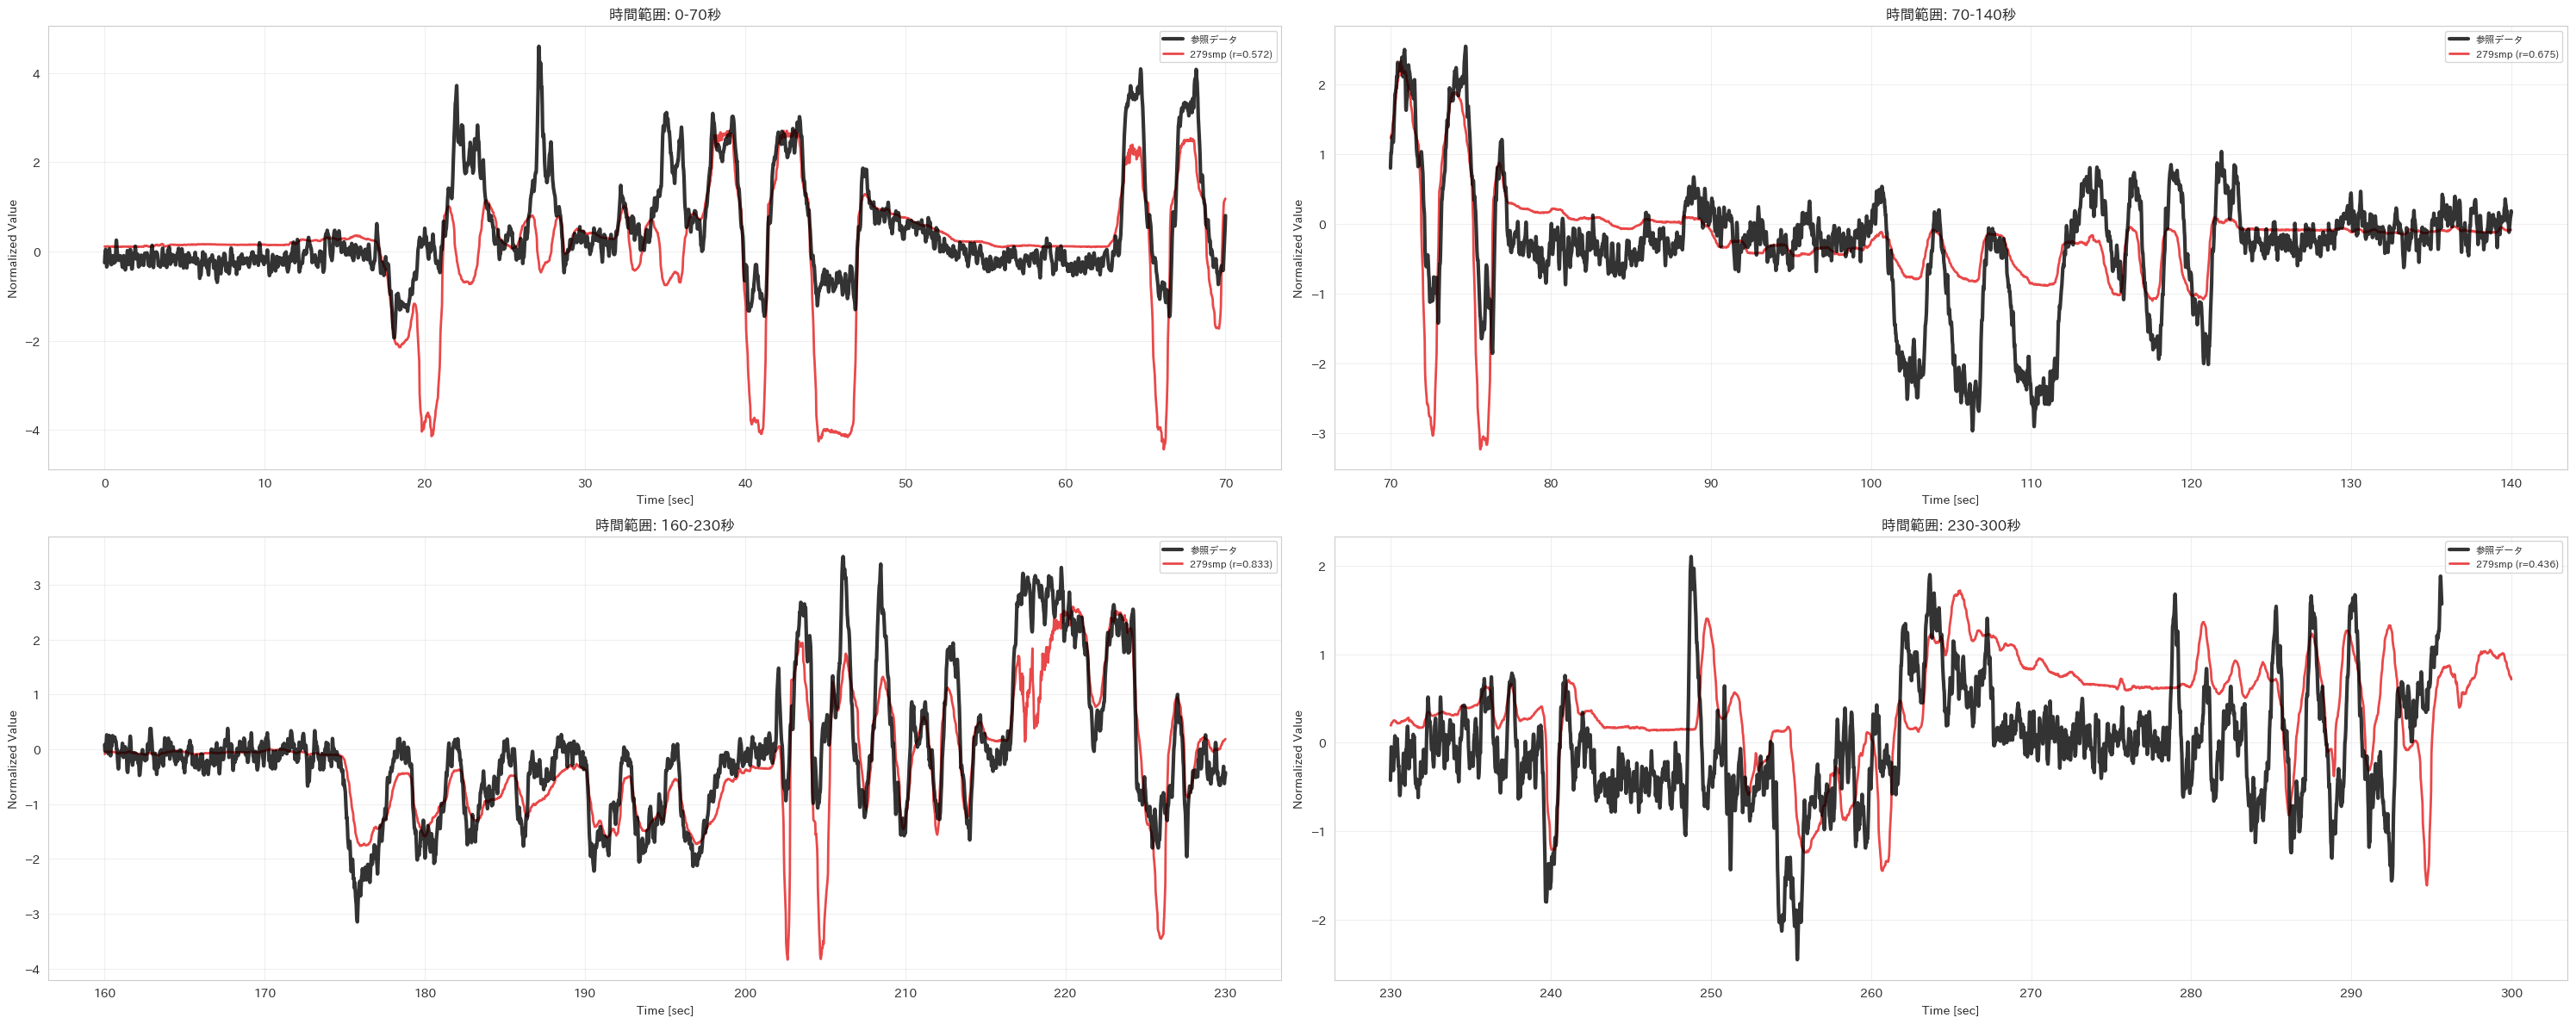


=== 指定ドリフト量の全体相関 ===
ドリフト 279 サンプル: 全体相関 = 0.6268


In [12]:
def compare_detailed_samples(df_ref, df_target, specific_drifts, 
                           col_ref='COP_X', col_target='圧力中心列_2',
                           focus_range=(200, 300)):
    """
    特定のドリフト量を詳細に比較（複数区間で表示）
    """    

    # --- 前処理 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 複数サブプロットで表示 ---
    fig, axes = plt.subplots(2, 2, figsize=(30, 12))
    axes = axes.flatten()
    
    # カラーマップ
    colors = plt.cm.Set1(np.linspace(0, 1, len(specific_drifts)))
    
    # 各注目区間をプロット
    focus_ranges = [
        (0, 70),     # 最初の部分
        (70, 140),   # 前半部分
        (160, 230),  # 中間部分
        (230, 300),  # 後半部分
    ]
    
    for ax_idx, (start_time, end_time) in enumerate(focus_ranges):
        if ax_idx >= len(axes):
            break
            
        ax = axes[ax_idx]
        
        # 参照データ
        mask_ref = (df_ref['time'] >= start_time) & (df_ref['time'] <= end_time)
        ax.plot(df_ref['time'][mask_ref], ref_norm[mask_ref], 
                color='black', linewidth=3, alpha=0.8, 
                label='参照データ', zorder=10)
        
        # 各ドリフト量
        for i, drift_samples in enumerate(specific_drifts):
            total_lag_time = drift_samples * dt_mean
            scale_factor = duration / (duration + total_lag_time)
            new_time = t_start + (df_target['time'] - t_start) * scale_factor
            
            # 相関係数計算（この区間のみ）
            mask_target = (new_time >= start_time) & (new_time <= end_time)
            if np.sum(mask_target) > 5:
                # この区間内での相関を計算
                time_in_range = new_time[mask_target]
                values_in_range = target_norm[mask_target]
                
                # 参照データと同じ時間点に補間
                from scipy import interpolate
                f_interp = interpolate.interp1d(time_in_range, values_in_range, 
                                              bounds_error=False, fill_value='extrapolate')
                target_aligned = f_interp(df_ref['time'][mask_ref])
                
                # 相関計算
                valid_mask = ~np.isnan(target_aligned)
                if np.sum(valid_mask) > 5:
                    correlation = np.corrcoef(ref_norm[mask_ref][valid_mask], 
                                            target_aligned[valid_mask])[0,1]
                else:
                    correlation = 0
            else:
                correlation = 0
            
            # プロット
            ax.plot(new_time[mask_target], target_norm[mask_target],
                   color=colors[i], linewidth=2, alpha=0.8,
                   label=f'{drift_samples}smp (r={correlation:.3f})')
        
        ax.set_title(f'時間範囲: {start_time}-{end_time}秒')
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 各ドリフト量の全体相関も表示
    print("\n=== 指定ドリフト量の全体相関 ===")
    for drift_samples in specific_drifts:
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        # new_time = df_target['time'] * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 全体相関
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            overall_correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
            print(f"ドリフト {drift_samples:3d} サンプル: 全体相関 = {overall_correlation:.4f}")

# 特定のドリフト量を詳細比較
compare_detailed_samples(
    df_filtered, # df_cleaned, 
    df_seat, 
    specific_drifts=[279],  # 比較したい特定の値
    # col_ref='FY_filtered', 
    # col_target='荷重(N)_1'

    col_ref='FY_filtered', 
    col_target='圧力中心行_1'

    # col_ref='FX_filtered', 
    # col_target='圧力中心列_1'


)

# ずれ量確定

In [13]:
df_filtered.columns

Index(['time', 'F1', 'F2', 'F3', 'F4', 'FX', 'FY', 'steer', 'pedal', 'trg',
       'FX_filtered', 'FY_filtered'],
      dtype='object')

補正情報:
  - ズレサンプル数: 279
  - ズレ時間換算  : 6.6434 sec
  - 適用スケール  : 0.97889242


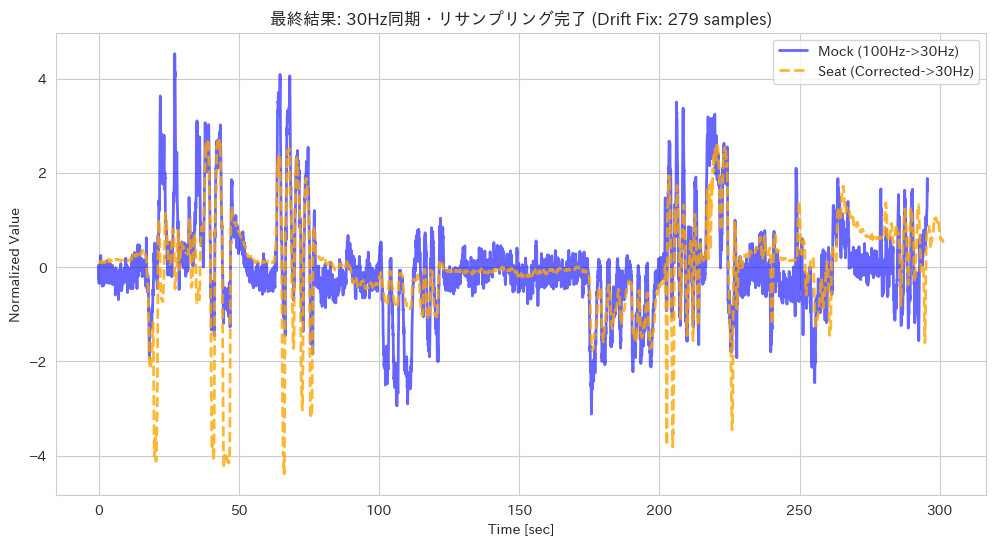

--- df_mock_30hz ---
       time        F1        F2        F3        F4     steer     pedal  \
0  0.000000  0.155334  0.393372  0.238647  0.134583  5.500114 -1.923096   
1  0.033333  0.221659  0.451152  0.357361  0.123087  5.500114 -1.862061   
2  0.066667  0.249227  0.459188  0.268046  0.059509  5.500114 -1.862061   
3  0.100000  0.167847  0.415344  0.302429  0.158691  5.500114 -1.862061   
4  0.133333  0.132649  0.395508  0.336711  0.154114  5.500114 -1.963786   

   FX_filtered  FY_filtered  
0     0.207351     0.243028  
1     0.229128     0.252508  
2     0.236972     0.257070  
3     0.231249     0.247784  
4     0.227759     0.238729  

--- df_seat_30hz ---
       time  平均圧力_1    最低圧力_1   ピーク圧力_1  接触域 (cm²)_1  選択領域(cm²)_1     接触 %_1  \
0  0.000000    0.39  0.130000  1.370000   535.480000      2580.65  20.750000   
1  0.033333    0.39  0.130000  1.368377   535.222844      2580.65  20.740260   
2  0.066667    0.39  0.130000  1.380000   532.869381      2580.65  20.652663   
3  0.1

In [15]:
# =========================================================
# 1. パラメータ設定
# =========================================================
BEST_DRIFT_SAMPLES = 279  # 見つけたベストな値
TARGET_FS = 30.0           # 目標サンプリング周波数 (Hz)

# =========================================================
# 2. df_seat の時間軸を補正（永続化）
# =========================================================
def apply_drift_correction(df, drift_samples):
    """
    見つけたドリフト量(samples)に基づいて時間軸を実際に書き換える
    """
    df_fixed = df.copy()
    
    # 統計量の計算
    dt_mean = df_fixed['time'].diff().mean()
    t_start = df_fixed['time'].min()
    t_end   = df_fixed['time'].max()
    duration = t_end - t_start
    
    # ズレ時間の計算 (35サンプル * 1サンプルの時間)
    total_lag_time = drift_samples * dt_mean
    
    # 伸縮率 (Scale Factor) の計算
    # visualize関数と同じ計算式を使用
    scale_factor = duration / (duration + total_lag_time)
    
    print(f"補正情報:")
    print(f"  - ズレサンプル数: {drift_samples}")
    print(f"  - ズレ時間換算  : {total_lag_time:.4f} sec")
    print(f"  - 適用スケール  : {scale_factor:.8f}")
    
    # 時間軸の更新
    df_fixed['time'] = t_start + (df_fixed['time'] - t_start) * scale_factor
    
    return df_fixed

# df_seat の時間を修正
df_seat_fixed = apply_drift_correction(df_seat, BEST_DRIFT_SAMPLES)


# =========================================================
# 3. 共通の30Hzへのリサンプリング
# =========================================================
def resample_to_target_hz(df, time_col, data_cols, target_fs):
    """
    指定されたDataFrameをtarget_fs(Hz)にリサンプリングする関数
    """
    # 元データ
    t_src = df[time_col].values
    # 時間軸の開始と終了（データの範囲内）
    t_min, t_max = t_src.min(), t_src.max()
    
    # 新しい時間軸 (startからendまで 1/fs 刻み)
    new_time = np.arange(t_min, t_max, 1.0 / target_fs)
    
    # 結果格納用DataFrame
    df_resampled = pd.DataFrame({time_col: new_time})
    
    # 指定されたデータ列を補間
    for col in data_cols:
        # 線形補間 (linear) または 3次スプライン (cubic)
        f = interpolate.interp1d(t_src, df[col].values, kind='linear', fill_value="extrapolate")
        df_resampled[col] = f(new_time)
        
    return df_resampled

# --- リサンプリング実行 ---

mock_cols = ['F1', 'F2', 'F3', 'F4', 'steer', 'pedal', 'FX_filtered', 'FY_filtered']
seat_cols = ['平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2']

# df_mock_tmp (元100Hz) -> 30Hz
df_mock_30hz = resample_to_target_hz(
    df_filtered, 
    time_col='time', 
    data_cols=mock_cols, # 必要な列を指定
    target_fs=TARGET_FS
)

# df_seat_fixed (補正済み40Hz) -> 30Hz
df_seat_30hz = resample_to_target_hz(
    df_seat_fixed, 
    time_col='time', 
    data_cols=seat_cols, # 必要な列を指定
    target_fs=TARGET_FS
)


# =========================================================
# 4. 結果の確認（結合・プロット）
# =========================================================

# 時間軸を完全に合わせるため、共通の時間範囲でデータを結合（Merge）しても良いですが、
# ここではプロットで確認します。

# 正規化関数（比較用）
def z_score(series):
    return (series - series.mean()) / series.std()

plt.figure(figsize=(12, 6))

# 青: df_mock (30Hz)
plt.plot(df_mock_30hz['time'], z_score(df_mock_30hz['FY_filtered']), 
         label='Mock (100Hz->30Hz)', color='blue', alpha=0.6, linewidth=2)

# オレンジ: df_seat (補正済み->30Hz)
plt.plot(df_seat_30hz['time'], z_score(df_seat_30hz['圧力中心行_1']), 
         label='Seat (Corrected->30Hz)', color='orange', alpha=0.8, linestyle='--', linewidth=2)

plt.title(f"最終結果: 30Hz同期・リサンプリング完了 (Drift Fix: {BEST_DRIFT_SAMPLES} samples)")
plt.xlabel("Time [sec]")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)

# ズレやすい後半を拡大
t_end = df_mock_30hz['time'].max()
# plt.xlim(t_end - 10, t_end) 

plt.show()

# データフレームの中身確認
print("--- df_mock_30hz ---")
print(df_mock_30hz.head())
print("\n--- df_seat_30hz ---")
print(df_seat_30hz.head())

#　ここから

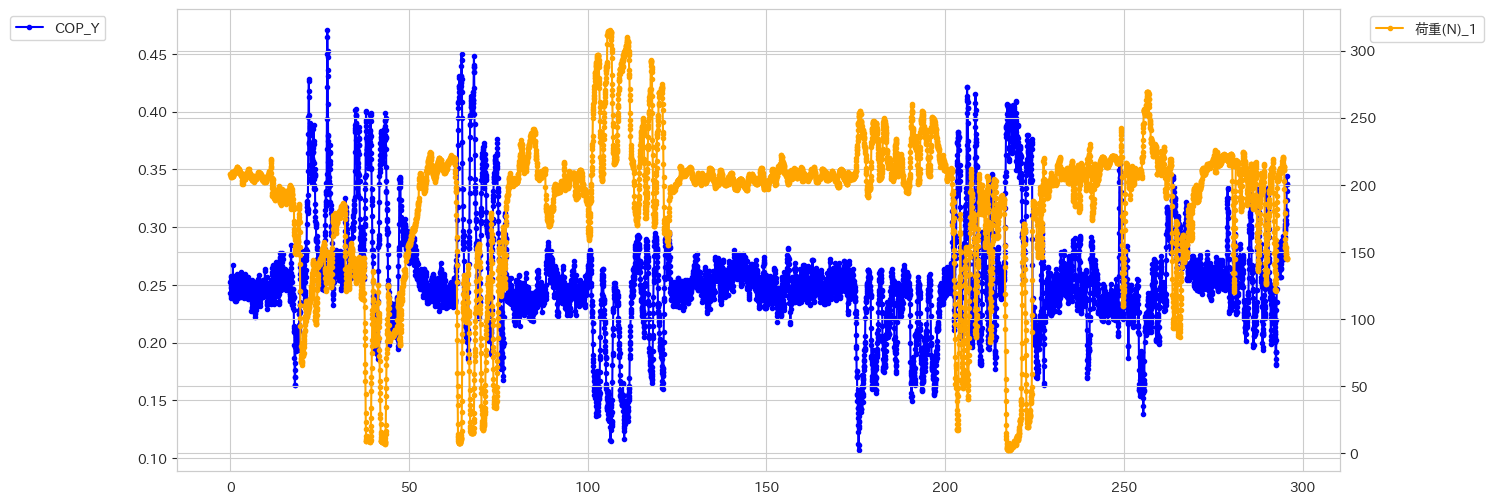

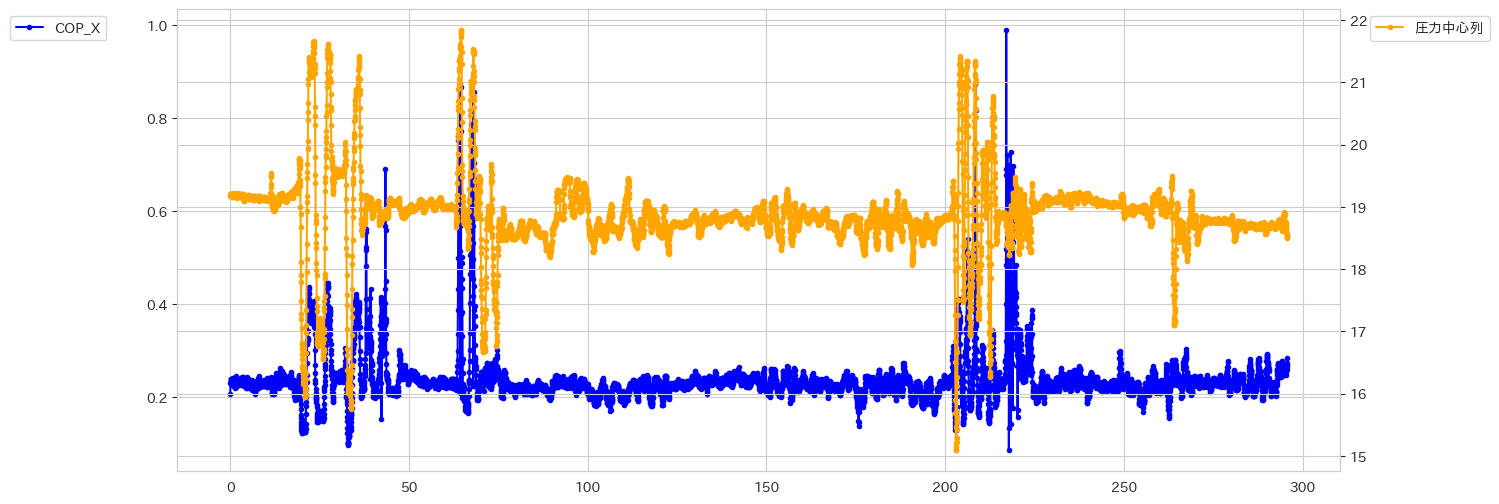

In [16]:
df_all = pd.merge(df_mock_30hz, df_seat_30hz, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['FY_filtered'],'.-',color='blue',label='COP_Y')
ax2.plot(df_all['time'],df_all['荷重(N)_1'],'.-',color='orange',label='荷重(N)_1') 
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all["time"],df_all['FX_filtered'],'.-',color='blue',label='COP_X')
ax2.plot(df_all['time'],df_all['圧力中心列_2'],'.-',color='orange',label='圧力中心列') # Y
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

# PLS

Step 2: モデルA（モドキCOP $X$ → 重要特徴量 $Y$） の構築に着手しましょう。ここでは、「4つの荷重センサの値」 から、** 先ほどの分析で重要と判明した **  「シート圧センサの特定の統計量（列座標、荷重、行座標）」 を、PLS回帰を用いて予測します。

## PLSを推奨する理由：
一言で言えば、**「入力センサ同士の相関（被り）を利用して、ノイズを消しつつ信号を取り出すのに最強だから」**です。

推奨理由 1：多重共線性（Multicollinearity）への強さ状況: 4つの荷重センサ（左前、右前、左後、右後）は独立していません。
* 例：人が「右」に傾いたとき、「右前」と「右後」は同時に増え、「左前」と「左後」は同時に減ります。<br>
* 問題点: 通常の回帰分析（重回帰）は、このように「連動する（相関が高い）入力変数」が入ってくると、計算が不安定になり、係数がめちゃくちゃな値（プラスマイナス逆転など）になります。<br>
* PLSの解決策:PLSは、4つのセンサの値をそのまま使うのではなく、「要するに右に傾いている」という新しい変数（潜在変数 / 成分） を内部で作ってから回帰します。これにより、センサ同士の相関をプラスの情報として活用できます。<br>

推奨理由 2：PCA（主成分分析）よりも「予測」に特化している「変数を圧縮するならPCAでいいのでは？」と思うかもしれません。しかし、PCAとPLSには決定的な違いがあります。
* PCA + 回帰:$X$ の中で「ばらつきが大きい方向」を探します。
  * 欠点: もし「ノイズのばらつき」が大きくても、PCAはそれを重要な情報だと勘違いします。$Y$ と関係ない変動を拾ってしまうリスクがあります。
* PLS 回帰:$X$ の中で**「$Y$ との相関（共分散）が最大になる方向」**を探します。
  * 利点: 「$Y$（シート圧の動き）を説明するのに役立つ成分だけ」を $X$ から抽出します。センサのノイズを除去し、純粋な信号だけを取り出せます。<br>

推奨理由 3：多目的変数（Multi-output）の同時予測状況: 今回のターゲット $Y$ は複数あります（圧力中心列、荷重、圧力中心行など）。これらはバラバラに動くのではなく、「体が前に倒れたら、荷重が増えて、行座標も動く」というように連動しています。
* Ridgeの場合: 通常、$Y_1, Y_2, Y_3...$ それぞれに対して別々のモデルを作ります（連動性を無視する）。
* PLSの場合: 複数の $Y$ をまとめて一つのモデルで学習します。「$X$ のこのパターンが出たら、$Y$ 全体がこう動く」という構造を捉えるため、個別に予測するよりも整合性の取れた結果が出やすくなります。



## なぜ Model A でこれらを選ぶのか？（選択と集中）<br>
これから作る Model A（モドキCOP $X$ → シート圧 $Y$）の目的は、あくまで「最終的に $Z$ を当てること」です。もし、$Z$ の予測に全く関係ない $Y$（例えば 最低圧力 や 選択領域）を一生懸命予測しても、最終精度は上がりません（無駄な努力になります）。逆に、$Z$ の予測に直結する 「列座標」や「荷重」さえ正確に予測できれば、他の $Y$ がデタラメでも、最終的な $Z$ の精度は高くなります。したがって、Model A の学習ターゲットは、**「精鋭メンバー」**に絞るべきです。

入力変数(X): ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered', 'pedal', 'steer']
出力変数(Y): ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1']

--- PLS Component Optimization ---
Components: 1 | Mean R2: -0.7041
Components: 2 | Mean R2: -0.7510
Components: 3 | Mean R2: -3.2287
Components: 4 | Mean R2: -1.5849
Components: 5 | Mean R2: -2.1933
Components: 6 | Mean R2: -1.3847
Components: 7 | Mean R2: -1.3310
Components: 8 | Mean R2: -1.3429
★ 推奨コンポーネント数: 1


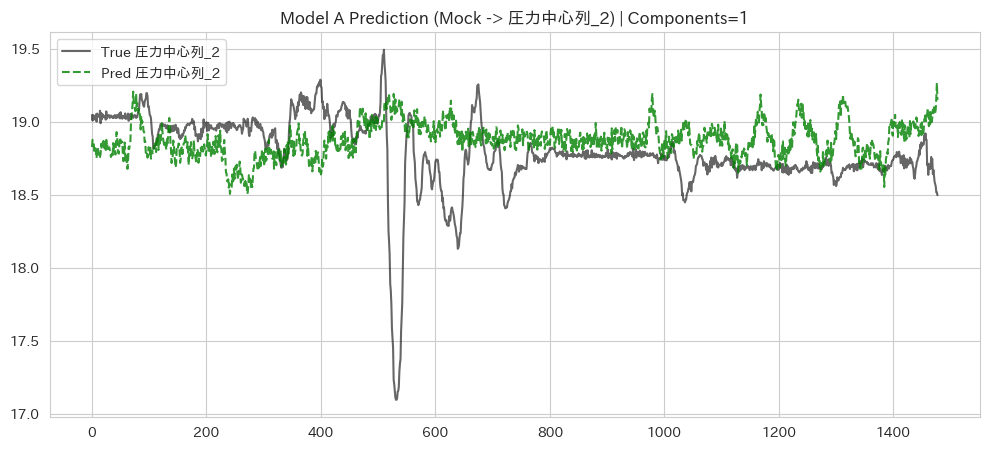


--- Final Test Scores (Last Fold) ---
圧力中心列_2        : R2 = -0.6224
荷重(N)_1        : R2 = -0.2009
圧力中心行_1        : R2 = -0.6526
圧力中心列_1        : R2 = -0.4284


In [18]:

# --- Cell 10: Model A (PLS Regression) Setup & Optimization ---
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================
# 【重要】列名の設定エリア
# ==========================================

# 1. 入力 X: モドキセンサ（4つの荷重センサ）の列名
# ※ データセットにある実際の列名に書き換えてください
# 例: ['Sensor_FL', 'Sensor_FR', 'Sensor_RL', 'Sensor_RR']
mock_sensor_cols = ['F1', 'F2', 'F3', 'F4','FX_filtered','FY_filtered' ,'pedal','steer'] 

# 2. 出力 Y: モデルBで「重要」と判明した特徴量 (ターゲット)
# ※ 先ほどの分析結果に基づき、以下の3〜4つを推奨します
target_features_A = [
    '圧力中心列_2', # COP X (左右) に最も効く
    '荷重(N)_1',    # COP Y (前後) に最も効く
    '圧力中心行_1', # COP Y の補正に効く
    '圧力中心列_1'  # 左右のバランス補正
]

# --- データの準備 ---
# 列が存在するかチェック
available_cols = df_all.columns.tolist()
X_cols = [c for c in mock_sensor_cols if c in available_cols]
Y_cols = [c for c in target_features_A if c in available_cols]

print(f"入力変数(X): {X_cols}")
print(f"出力変数(Y): {Y_cols}")

if len(X_cols) == 0:
    raise ValueError("エラー: モドキセンサの列が見つかりません。列名を修正してください。")

# NaNを含む行を削除してデータセットAを作成
df_A = df_all[X_cols + Y_cols].dropna()
X_A = df_A[X_cols]
Y_A = df_A[Y_cols]

# ==========================================
# 最適な成分数 (n_components) の探索
# ==========================================
# 入力が4次元なので、成分数は 1, 2, 3, 4 のいずれかになります
components_range = range(1, len(X_cols) + 1)
scores = []

# TimeSeriesSplitで評価
tscv = TimeSeriesSplit(n_splits=5)

print("\n--- PLS Component Optimization ---")
for n in components_range:
    pls = PLSRegression(n_components=n)
    # cross_val_scoreはデフォルトでR2を返します
    cv_scores = cross_val_score(pls, X_A, Y_A, cv=tscv, scoring='r2')
    mean_score = np.mean(cv_scores)
    scores.append(mean_score)
    print(f"Components: {n} | Mean R2: {mean_score:.4f}")

best_n = components_range[np.argmax(scores)]
print(f"★ 推奨コンポーネント数: {best_n}")

# ==========================================
# 最適モデルでの学習と可視化
# ==========================================
# 推奨コンポーネント数でモデルを確定
final_pls = PLSRegression(n_components=best_n)

# 最後の1区間をテストとして可視化（時系列分割の最後）
train_idx, test_idx = list(tscv.split(X_A))[-1]
X_train, X_test = X_A.iloc[train_idx], X_A.iloc[test_idx]
Y_train, Y_test = Y_A.iloc[train_idx], Y_A.iloc[test_idx]

final_pls.fit(X_train, Y_train)
Y_pred = final_pls.predict(X_test)

# 結果プロット (最初のターゲット変数を表示)
target_idx = 0 # 0番目のターゲット (例: 圧力中心列_2)
col_name = Y_cols[target_idx]

plt.figure(figsize=(12, 5))
plt.plot(Y_test.values[:, target_idx], label=f'True {col_name}', color='black', alpha=0.6)
plt.plot(Y_pred[:, target_idx], label=f'Pred {col_name}', color='green', linestyle='--', alpha=0.8)
plt.title(f"Model A Prediction (Mock -> {col_name}) | Components={best_n}")
plt.legend()
plt.grid(True)
plt.show()

# 全ターゲットのスコア表示
print("\n--- Final Test Scores (Last Fold) ---")
for i, col in enumerate(Y_cols):
    r2 = r2_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"{col:15s}: R2 = {r2:.4f}")

このコードで確認すること推奨コンポーネント数:おそらく 2 または 3 になるはずです。もし 4 が選ばれた場合、ノイズ除去があまり効いていない（生の情報を全部使ったほうが良い）状態ですが、それでもPLSを使うメリット（多目的変数の同時学習）はあります。R2スコア:ここで $R^2 > 0.8$ 程度出ていれば、「安価なセンサでも、シート圧センサの代わりが務まる」ことの証明になります。特に 圧力中心列（左右） と 荷重（前後） の精度に注目してください。実行結果が出ましたら教えてください。もし精度が低い場合、**「センサ配置の問題」や「非線形性の考慮（入力の2乗項を追加する）」**などの対策を提案します。

--- 診断: ランダム分割による物理相関チェック ---
Target: 圧力中心列_2         | Random Split R2: 0.6346
Target: 荷重(N)_1         | Random Split R2: 0.6355
Target: 圧力中心行_1         | Random Split R2: 0.4848
Target: 圧力中心列_1         | Random Split R2: 0.5703


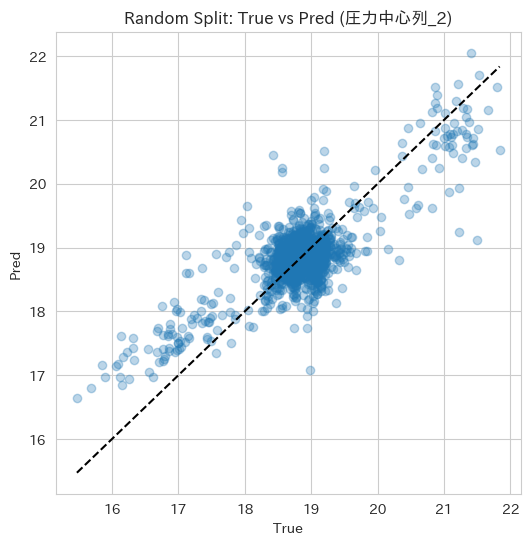

In [20]:
# --- Cell 10-Check: Random Split Sanity Check ---
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

print("--- 診断: ランダム分割による物理相関チェック ---")

# 1. シャッフルありで分割
X_train_r, X_test_r, Y_train_r, Y_test_r = train_test_split(
    X_A, Y_A, test_size=0.2, random_state=42, shuffle=True
)

# 2. PLS学習 (成分数は3くらいで固定)
check_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', PLSRegression(n_components=3))
])

check_model.fit(X_train_r, Y_train_r)
Y_pred_r = check_model.predict(X_test_r)

# 3. 評価
for i, col in enumerate(Y_cols):
    r2 = r2_score(Y_test_r.iloc[:, i], Y_pred_r[:, i])
    print(f"Target: {col:15s} | Random Split R2: {r2:.4f}")

# 散布図 (Target 0)
plt.figure(figsize=(6, 6))
plt.scatter(Y_test_r.iloc[:, 0], Y_pred_r[:, 0], alpha=0.3)
plt.title(f"Random Split: True vs Pred ({Y_cols[0]})")
plt.xlabel("True")
plt.ylabel("Pred")
plt.plot([Y_test_r.iloc[:, 0].min(), Y_test_r.iloc[:, 0].max()], 
         [Y_test_r.iloc[:, 0].min(), Y_test_r.iloc[:, 0].max()], 'k--')
plt.grid(True)
plt.show()

Drift removal applied to: ['F1', 'F2', 'F3', 'F4'] (Window=300)

--- Model A Evaluation (After Drift Removal) ---
Fold 1: R2 Score = 0.3175
Fold 2: R2 Score = -9.3306
Fold 3: R2 Score = -0.9137
Fold 4: R2 Score = 0.3544
Fold 5: R2 Score = -0.9928
Average R2 (Detrended): -2.1131


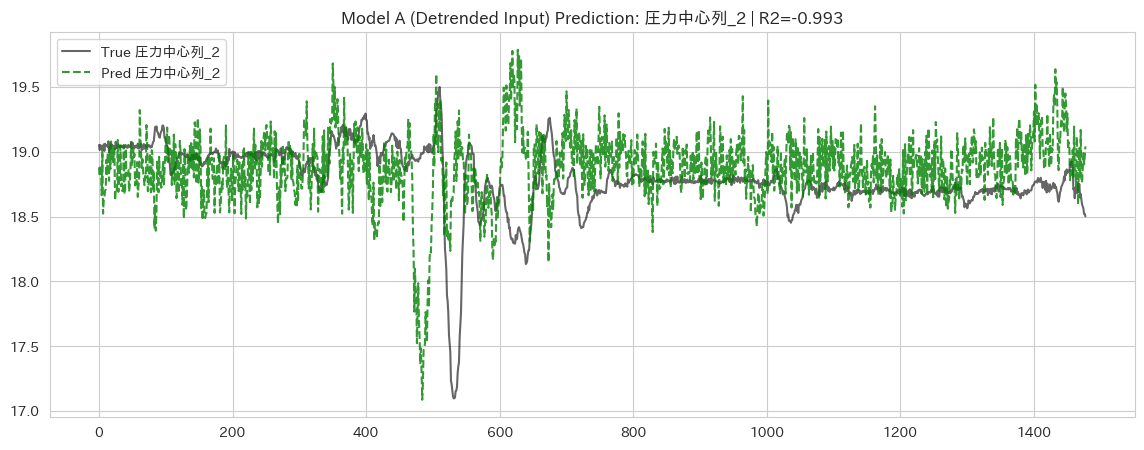

In [25]:
# --- Cell 13: Drift Removal (High-Pass Filter) & Re-Evaluation ---

# 1. フィルタリング設定
# 荷重センサはドリフトしやすいのでフィルタをかける
drift_sensitive_cols = ['F1', 'F2', 'F3', 'F4']#,'FX_filtered','FY_filtered']
# 操作情報は絶対値が大事なのでそのまま
stable_cols = ['pedal', 'steer']

# ウィンドウサイズの設定
# サンプリング周波数によりますが、「ドリフト（数分単位）」を除去し、
# 「カーブや加減速（数秒単位）」は残したいです。
# データ点数で指定します（例: 100Hzで5秒なら500点）
# ここでは仮に 300点 としますが、データのHzに合わせて調整してください
window_size = 300 

# 2. データの加工関数
def apply_detrend(df, target_cols, window):
    df_out = df.copy()
    # 移動平均を引く（ハイパスフィルタ効果）
    # min_periods=1 で初期データの欠損を防ぐ
    rolling_mean = df[target_cols].rolling(window=window, min_periods=1).mean()
    df_out[target_cols] = df[target_cols] - rolling_mean
    return df_out

# 3. 入力データ(X)の作成と加工
# まず生データを抽出
df_model_A = df_all[mock_sensor_cols + target_features_A].dropna()

# 荷重センサ部分だけデトレンド（ドリフト除去）
X_A_raw = df_model_A[mock_sensor_cols]
X_A_detrended = apply_detrend(X_A_raw, drift_sensitive_cols, window_size)

# ターゲット(Y)はそのままでOK（あるいはYもドリフトするならYもデトレンドする）
# 今回はまず「Xのドリフト」が主犯と見て、Yはそのまま予測させます
Y_A = df_model_A[target_features_A]

print(f"Drift removal applied to: {drift_sensitive_cols} (Window={window_size})")

# 4. 再度 TimeSeriesSplit で評価
tscv = TimeSeriesSplit(n_splits=5)
n_components = 3 # ランダム分割で良さそうだった成分数

scores_detrend = []

print("\n--- Model A Evaluation (After Drift Removal) ---")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_A_detrended)):
    X_train, X_test = X_A_detrended.iloc[train_idx], X_A_detrended.iloc[test_idx]
    Y_train, Y_test = Y_A.iloc[train_idx], Y_A.iloc[test_idx]
    
    # PLSモデル
    pls_model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', PLSRegression(n_components=n_components))
    ])
    
    pls_model.fit(X_train, Y_train)
    Y_pred = pls_model.predict(X_test)
    
    r2 = r2_score(Y_test, Y_pred)
    scores_detrend.append(r2)
    
    print(f"Fold {fold+1}: R2 Score = {r2:.4f}")

avg_r2 = np.mean(scores_detrend)
print(f"Average R2 (Detrended): {avg_r2:.4f}")

# 5. 結果の可視化 (最後のFold)
target_idx = 0
col_name = target_features_A[target_idx]

plt.figure(figsize=(14, 5))
plt.plot(Y_test.values[:, target_idx], label=f'True {col_name}', color='black', alpha=0.6)
plt.plot(Y_pred[:, target_idx], label=f'Pred {col_name}', color='green', linestyle='--', alpha=0.8)
plt.title(f"Model A (Detrended Input) Prediction: {col_name} | R2={r2:.3f}")
plt.legend()
plt.grid(True)
plt.show()

Pre-processing applied: Smoothing(X) -> Detrending(X & Y)

--- Model A Evaluation (Relative Motion Prediction) ---
Fold 1: R2 Score = 0.5155
Fold 2: R2 Score = -3.5636
Fold 3: R2 Score = 0.1602
Fold 4: R2 Score = 0.5949
Fold 5: R2 Score = -0.6983
Average R2 (Motion): -0.5982


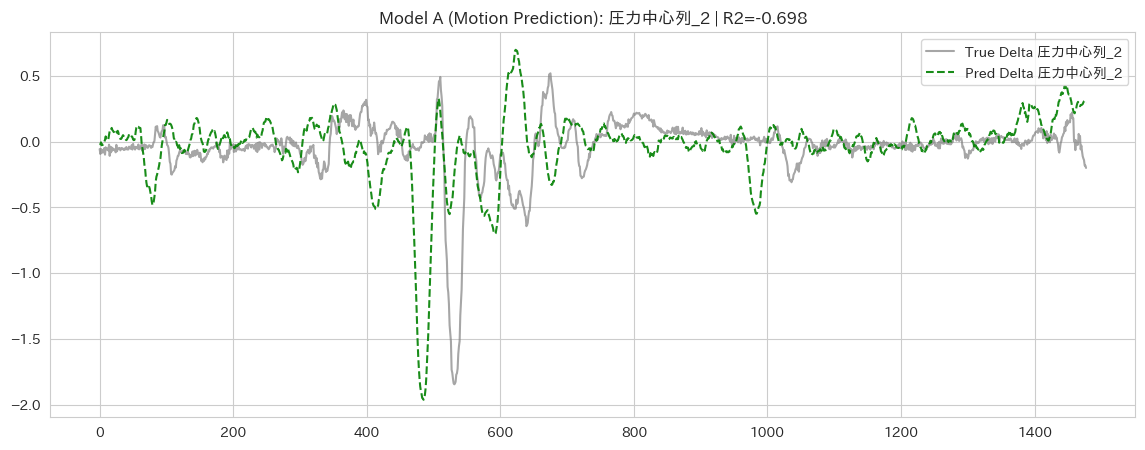

In [35]:
# --- Cell 13 (修正版): Double Filtering (Smoothing X + Detrending X&Y) ---

# 1. 設定
# ドリフト除去対象: 荷重センサ(X) と シート圧ターゲット(Y) 両方！
drift_sensitive_X = ['F1', 'F2', 'F3', 'F4','FX_filtered','FY_filtered']
drift_sensitive_Y = target_features_A

# コンテキスト（操作）は絶対値のまま使う
context_cols = ['pedal', 'steer']

# フィルタ設定
# (A) スムージング用（ノイズ除去）: 短い窓 (例: 10〜20サンプル = 0.1〜0.2秒)
smooth_window = 15 
# (B) デトレンド用（ドリフト除去）: 長い窓 (例: 300サンプル = 3〜5秒)
detrend_window = 300

# 2. 加工関数の定義
def apply_preprocessing(df, x_cols, y_cols, smooth_win, detrend_win):
    df_out = df.copy()
    
    # --- Step 1: Smoothing (Low-Pass Filter) ---
    # Xの高周波ノイズ（緑線のギザギザ）を消す
    # Yは元々滑らかそうなのでそのままでも良いが、位相を合わせるために軽くかけても良い
    # ここではXのみ強めにかけます
    df_out[x_cols] = df_out[x_cols].rolling(window=smooth_win, min_periods=1, center=True).mean()
    
    # --- Step 2: Detrending (High-Pass Filter) ---
    # XとYの両方から「直近の移動平均」を引く
    # これにより「絶対位置」ではなく「動き(Dynamics)」の関係を学習させる
    
    # Xのデトレンド
    x_mean = df_out[x_cols].rolling(window=detrend_win, min_periods=1).mean()
    df_out[x_cols] = df_out[x_cols] - x_mean
    
    # Yのデトレンド (★ここが追加ポイント)
    y_mean = df_out[y_cols].rolling(window=detrend_win, min_periods=1).mean()
    df_out[y_cols] = df_out[y_cols] - y_mean
    
    return df_out

# 3. データ作成と加工
# まず必要な列を全て抜き出す
cols_needed = drift_sensitive_X + context_cols + drift_sensitive_Y
df_raw = df_all[cols_needed].dropna()

# 前処理の適用
df_processed = apply_preprocessing(
    df_raw, 
    drift_sensitive_X, 
    drift_sensitive_Y, 
    smooth_window, 
    detrend_window
)

# モデル用データに分割
X_A_proc = df_processed[drift_sensitive_X + context_cols] # 荷重(加工済) + 操作(生)
Y_A_proc = df_processed[drift_sensitive_Y]                # シート圧(加工済)

print("Pre-processing applied: Smoothing(X) -> Detrending(X & Y)")

# 4. TimeSeriesSplit で評価
tscv = TimeSeriesSplit(n_splits=5)
n_components = 3 # 安定の3

scores_final = []

print("\n--- Model A Evaluation (Relative Motion Prediction) ---")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_A_proc)):
    X_train, X_test = X_A_proc.iloc[train_idx], X_A_proc.iloc[test_idx]
    Y_train, Y_test = Y_A_proc.iloc[train_idx], Y_A_proc.iloc[test_idx]
    
    # PLSモデル
    pls_model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', PLSRegression(n_components=n_components))
    ])
    
    pls_model.fit(X_train, Y_train)
    Y_pred = pls_model.predict(X_test)
    
    r2 = r2_score(Y_test, Y_pred)
    scores_final.append(r2)
    
    print(f"Fold {fold+1}: R2 Score = {r2:.4f}")

avg_r2 = np.mean(scores_final)
print(f"Average R2 (Motion): {avg_r2:.4f}")

# 5. 可視化
target_idx = 0
col_name = target_features_A[target_idx]

plt.figure(figsize=(14, 5))
# Y_testもデトレンド済み（変化量）になっていることに注意
plt.plot(Y_test.values[:, target_idx], label=f'True Delta {col_name}', color='gray', alpha=0.7)
plt.plot(Y_pred[:, target_idx], label=f'Pred Delta {col_name}', color='green', linestyle='--', alpha=0.9)
plt.title(f"Model A (Motion Prediction): {col_name} | R2={scores_final[-1]:.3f}")
plt.legend()
plt.grid(True)
plt.show()